Import necessary libraries


In [40]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

The data set used, originated from a google sheet where Null data can be represented as #N/A or similar. These are changed to the NaN type upon read.

In [41]:
# Loading the labeled dataset
df = pd.read_csv('Labeled.csv', na_values=['#N/A', 'N/A', '#N/A N/A'])

In [42]:
# Display column names and data types
print(df.info())

# Show a summary of the data
print(df.describe())

# Check for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          1111 non-null   int64  
 1   Date       1111 non-null   object 
 2   XAU BGNL   1111 non-null   float64
 3   ECSURPUS   1111 non-null   float64
 4   BDIY       1111 non-null   float64
 5   CRY        1111 non-null   float64
 6   DXY        1111 non-null   float64
 7   JPY        1111 non-null   float64
 8   GBP        1111 non-null   float64
 9   Cl1        1111 non-null   float64
 10  VIX        1111 non-null   float64
 11  USGG30YR   1111 non-null   float64
 12  GT10       1111 non-null   float64
 13  USGG2YR    1111 non-null   float64
 14  USGG3M     1111 non-null   float64
 15  US0001M    1111 non-null   float64
 16  GTDEM30Y   1111 non-null   float64
 17  GTDEM10Y   1111 non-null   float64
 18  GTDEM2Y    1111 non-null   float64
 19  EONIA      1111 non-null   float64
 20  GTITL30Y

It seems that all enteries require no further cleaning. Now we will drop highly corrolated columns as they provide no additional value.

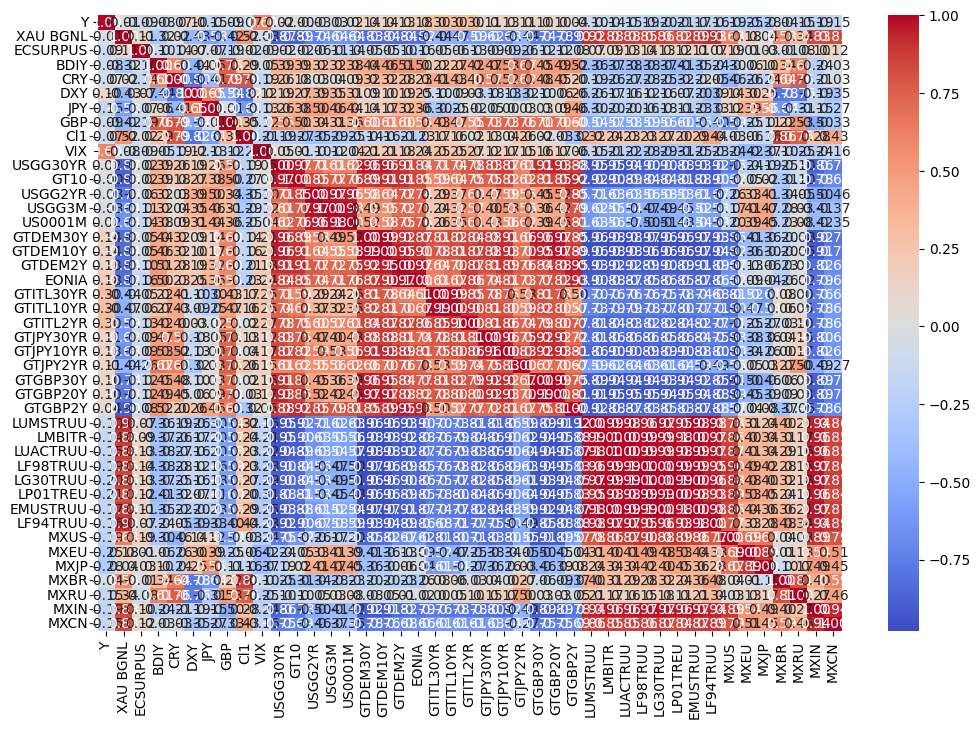

In [43]:
numeric_columns = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

We eill drop these highly corralated columns

In [44]:
high_corr_cols = ['LUMSTRUU', 'LMBITR', 'LUACTRUU', 'LF98TRUU', 'LG30TRUU', 'LP01TREU']
df.drop(columns=high_corr_cols,inplace=True)

It's time to make sure the data is standardizable

/var/folders/b4/58zwhnj121l_6vb8cbv7zdfw0000gn/T/ipykernel_93466/4170206449.py:6: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


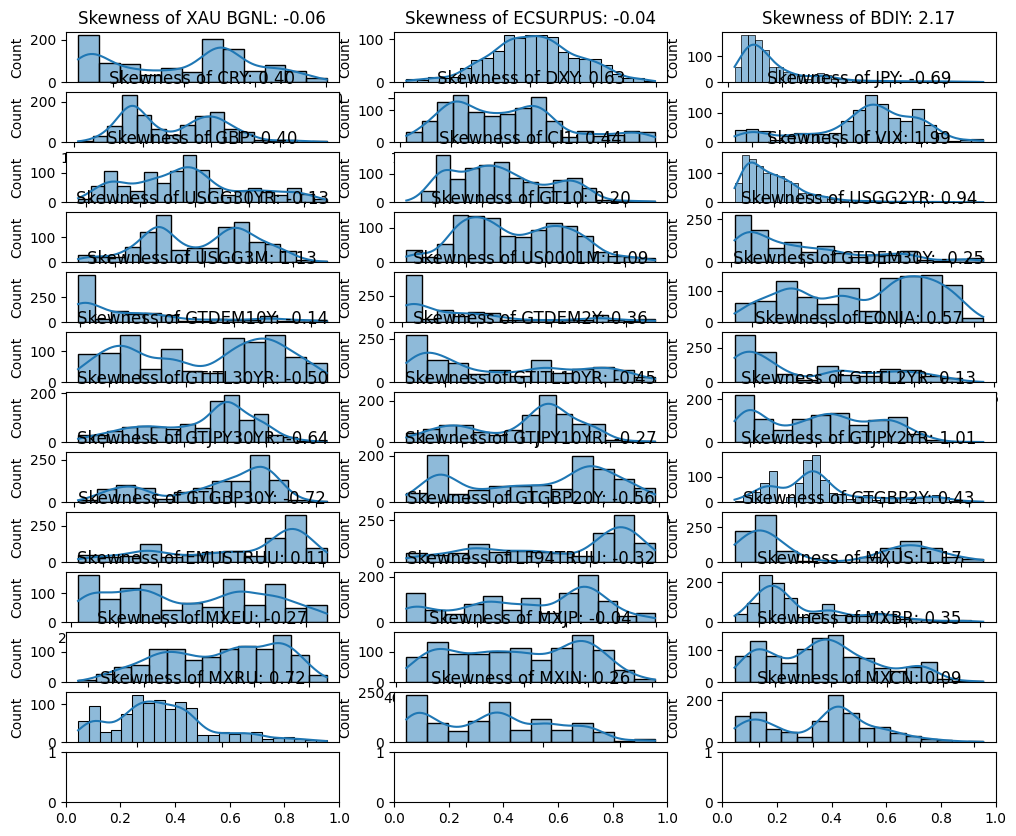

In [45]:
# Plot histogram and density plot for each feature
fig, axes = plt.subplots(nrows=len(df.iloc[:, 2:].columns)//3 + 1, ncols=3, figsize=(12, 10))
for i, column in enumerate(df.iloc[:, 2:].columns):
    sns.histplot(df[column], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Skewness of {column}: {df[column].skew():.2f}')
plt.tight_layout()
plt.show()

Most of the features blatantly to be non-gaussian distributions - therfore we will skip gaussian tests and conclude that this data must be normalized instead of standardized.

In [46]:

# Normalize the numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[numeric_columns])

# Replaing the original columns with the scaled columns
df[numeric_columns] = df_scaled



We will also remove low variance columns which provide no additional context for our model

In [47]:
# Separate numeric and non-numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns

# Apply VarianceThreshold to numeric columns
selector = VarianceThreshold(threshold=0.01)
selector.fit(df[numeric_columns])

# Get columns to keep
columns_to_keep = numeric_columns[selector.get_support()]

# Combine filtered numeric columns with non-numeric columns
df = pd.concat([df[non_numeric_columns], df[columns_to_keep]], axis=1)

# Print the updated DataFrame
print(f"Remaining columns: {df.head().shape[1]}")


Remaining columns: 38


With our data cleaned and normalized, we will change the date column into a proper datetime format and features for year and month.

This is in hopes that cycles of months or years could predict a crash.

In [48]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Two extra features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

Finally we will export our dataset for model creation

In [49]:
df.to_csv('clean_labeled_data.csv', index=False)